In [1]:
#remove all warnings
import pandas as pd
from warnings import simplefilter
pd.options.mode.chained_assignment = None 
simplefilter(action='ignore', category=FutureWarning)

In [7]:
#create dataframe from subset of all CSV data
top=pd.read_csv("SpotifyFeatures.csv")
df=top.loc[top['genre'] == 'Folk']
# print(df["popularity"].mean())
# print(df["popularity"].max())
# print(df["popularity"].std())

49.94020862458329
84
8.218284338066605


In [350]:
#add a column that groups by popularity 
import math
dict = df.to_dict('records')     
for record in dict:
    record.update(ranking=math.ceil(record["popularity"]/10)) #splitting popularity into 10 categories
    #concatinating groupings into two relavant categories
    if (record["ranking"]>=8):
        record.update(ranking=8)
    if (record["ranking"]<=5):
        record.update(ranking=5)

    
df = pd.DataFrame(dict)

print(df.loc[df["ranking"] == 1].shape)
print(df.loc[df["ranking"] == 2].shape)
print(df.loc[df["ranking"] == 3].shape)
print(df.loc[df["ranking"] == 4].shape)
print(df.loc[df["ranking"] == 5].shape) #### 
print(df.loc[df["ranking"] == 6].shape)
print(df.loc[df["ranking"] == 7].shape)
print(df.loc[df["ranking"] == 8].shape) #### 
print(df.loc[df["ranking"] == 9].shape) ####
print(df.loc[df["ranking"] == 10].shape) #### 


#getting even distribution of samples for each of the two most relevant groupings
bottomFiftyPercent= pd.DataFrame(df.loc[df["ranking"] == 5][:133]) 
topTwentyPercent= pd.DataFrame(df.loc[df["ranking"] == 8][:133]) 
concat = pd.concat([bottomFiftyPercent,topTwentyPercent])


#concat.shape
#df.popularity.max() # == 84 


(0, 19)
(0, 19)
(0, 19)
(0, 19)
(5450, 19)
(2779, 19)
(937, 19)
(133, 19)
(0, 19)
(0, 19)


(266, 19)

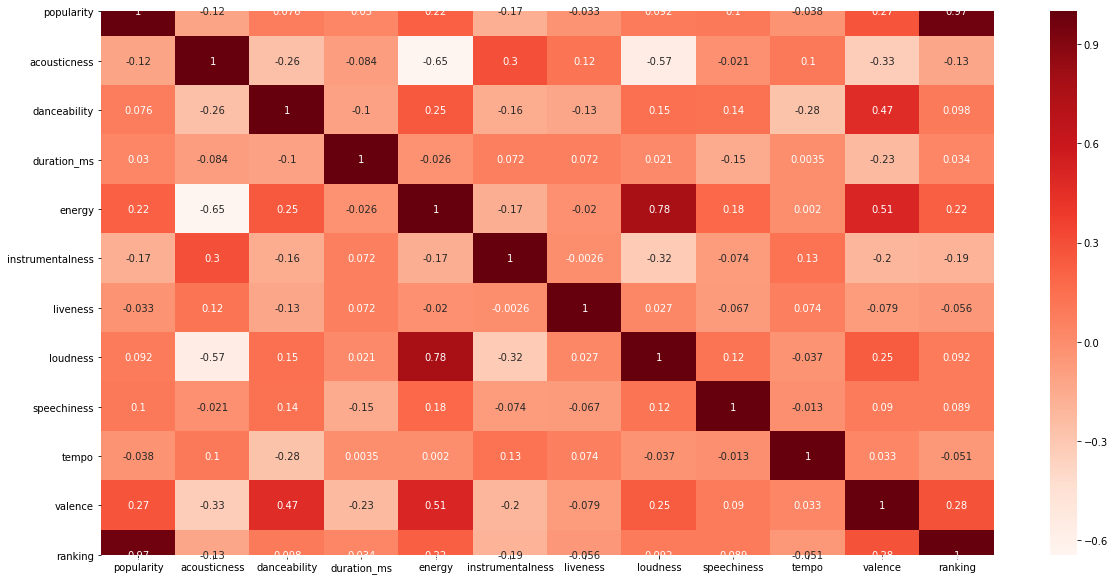

In [351]:
#determine which features are relevant out of all the following provided by spotifys API:
    #danceability,energy,key,loudness,mode,speechiness,
    #acousticness,instrumentalness,liveness,valence,tempo,
    #duration_ms,time_signature
    
#Use Pearson Correlation to determine individual feature importance:
import matplotlib.pyplot as plt
import seaborn as sns
X = concat.drop("ranking",1)   #Feature Matrix
y = concat["ranking"]          #Target Col
plt.figure(figsize=(20,10))
cor = concat.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [352]:
#determine individually correlated features vars to target var 
    #unfortunately, there is a very low correlation between each feature and the target var, popularity. 
    #No feature has a correlation higher than .3
    
cor_target = abs(cor["ranking"])

relevant_features = cor_target[cor_target>=0.18]
relevant_features

#below you can see the top features that correlate most to popularity are energy, instrum., and valence

popularity          0.969970
energy              0.223503
instrumentalness    0.194225
valence             0.284880
ranking             1.000000
Name: ranking, dtype: float64

In [415]:
#first testing the predictive accuracies of 3 models after cross fold validation 

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict

kf=StratifiedKFold(n_splits=3)
scores_LR = []
scores_SVM = []
scores_CLF = []

def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

#Marking data as feature versus target variables
feature_cols=['instrumentalness','valence']
X=concat[feature_cols] #dependent vars
#changing target var to binary 
binaryY={5:0,8:1}
concat.replace({'ranking':binaryY}, inplace=True)
y=concat["ranking"] #target var

for train_index,test_index in kf.split(X,y): 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    
    scores_LR.append(get_score(LogisticRegression(),X_train, X_test, y_train, y_test))
    scores_SVM.append(get_score(SVC(C=9),X_train, X_test, y_train, y_test))
    scores_CLF.append(get_score(DecisionTreeClassifier(max_depth=6),X_train, X_test, y_train, y_test))
    
print("Percent of Successful Predictions of Model after 3 Fold Cross Validation Splitting:")
print("\nLogistic Regression Accuracy: \n\t%0.2f (+/- %0.2f)" % (np.mean(scores_LR), np.std(scores_LR) * 2))
print("\nSVM Accuracy: \n\t%0.2f (+/- %0.2f)" % (np.mean(scores_SVM), np.std(scores_SVM) * 2))
print("\nDecision Tree Accuracy: \n\t%0.2f (+/- %0.2f)" % (np.mean(scores_CLF), np.std(scores_CLF) * 2))

Percent of Successful Predictions of Model after 3 Fold Cross Validation Splitting:

Logistic Regression Accuracy: 
	0.65 (+/- 0.10)

SVM Accuracy: 
	0.64 (+/- 0.07)

Decision Tree Accuracy: 
	0.64 (+/- 0.15)


In [454]:
#second, creating confusion matrices to see the types of errors exhibited by each model: a more verbose description of model behavior

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1)

##confusion matrix per model 
clf = DecisionTreeClassifier(max_depth=5) #6 gets highest 
clf.fit(X_train,y_train)
clf_pred_train = clf.predict(X_train)
clf_pred_test = clf.predict(X_test)
clf_accuracy_train = accuracy_score(clf_pred_train,y_train)
clf_accuracy_test = accuracy_score(clf_pred_test,y_test)
clf_precision, clf_recall, clf_fscore, clf_support = score(y_test, clf_pred_test)
print('CLF\ntraining accuracy {}'.format(clf_accuracy_train))
print('testing accuracy {}'.format(clf_accuracy_test))
print('precision: {}'.format(clf_precision))
print('recall: {}'.format(clf_recall))
print('fscore: {}'.format(clf_fscore))
print('support: {}'.format(clf_support))
print('CLF confusion matrices:\n {}'.format(multilabel_confusion_matrix(y_test, clf_pred_test)))


svc = SVC(C=2)
svc.fit(X_train,y_train)
svc_pred_train = svc.predict(X_train)
svc_pred_test = svc.predict(X_test)
svc_accuracy_train = accuracy_score(svc_pred_train,y_train)
svc_accuracy_test = accuracy_score(svc_pred_test,y_test)
svc_precision, svc_recall, svc_fscore, svc_support = score(y_test, svc_pred_test)
print('\n\nSVC\ntraining accuracy {}'.format(svc_accuracy_train))
print('testing accuracy {}'.format(svc_accuracy_test))
print('precision: {}'.format(svc_precision))
print('recall: {}'.format(svc_recall))
print('fscore: {}'.format(svc_fscore))
print('support: {}'.format(svc_support))
print('SVC confusion matrices:\n {}'.format(multilabel_confusion_matrix(y_test, svc_pred_test)))

lg = LogisticRegression()
lg.fit(X_train,y_train)
lg_pred_train = lg.predict(X_train)
lg_pred_test = lg.predict(X_test)
lg_accuracy_train = accuracy_score(lg_pred_train,y_train)
lg_accuracy_test = accuracy_score(lg_pred_test,y_test)
lg_precision, lg_recall, lg_fscore, lg_support = score(y_test, lg_pred_test)
print('\n\nLogistic Regression\ntraining accuracy {}'.format(lg_accuracy_train))
print('testing accuracy {}'.format(lg_accuracy_test))
print('precision: {}'.format(lg_precision))
print('recall: {}'.format(lg_recall))
print('fscore: {}'.format(lg_fscore))
print('support: {}'.format(lg_support))
print('LR confusion matrices:\n {}'.format(multilabel_confusion_matrix(y_test, lg_pred_test)))

CLF
training accuracy 0.7365591397849462
testing accuracy 0.6625
precision: [0.65306122 0.67741935]
recall: [0.76190476 0.55263158]
fscore: [0.7032967  0.60869565]
support: [42 38]
CLF confusion matrices:
 [[[21 17]
  [10 32]]

 [[32 10]
  [17 21]]]


SVC
training accuracy 0.6451612903225806
testing accuracy 0.625
precision: [0.625 0.625]
recall: [0.71428571 0.52631579]
fscore: [0.66666667 0.57142857]
support: [42 38]
SVC confusion matrices:
 [[[20 18]
  [12 30]]

 [[30 12]
  [18 20]]]


Logistic Regression
training accuracy 0.6505376344086021
testing accuracy 0.625
precision: [0.63043478 0.61764706]
recall: [0.69047619 0.55263158]
fscore: [0.65909091 0.58333333]
support: [42 38]
LR confusion matrices:
 [[[21 17]
  [13 29]]

 [[29 13]
  [17 21]]]


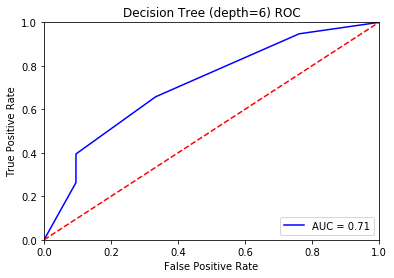

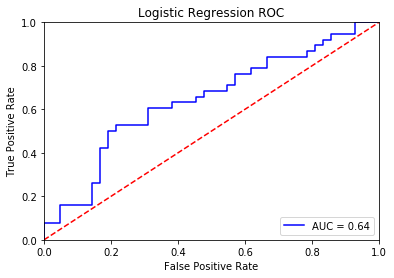

In [435]:
#third, evaluuating how each model performs with AOC  

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Decision Tree (depth=6) ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#####################################################
probs = lg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Logistic Regression ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [446]:
# #garbage code for reference:
# predicted = [1,2,3,4,5,1,2,1,1,4,5] 
# y_test = [1,2,3,4,5,1,2,1,1,4,1]

# precision, recall, fscore, support = score(y_test, predicted)
# print('precision: {}'.format(precision)) #Precision is the fraction of predicted events that actually occur
# print('recall: {}'.format(recall)) #Recall (sensitivity) is the fraction of events predicted correctly 
# print('fscore: {}'.format(fscore)) #f1 score is the harmonic mean of recall and precision, with a higher score as a better model
# print('support: {}'.format(support)) #number of predictions per classification

# from sklearn.metrics import multilabel_confusion_matrix
# y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
# y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
# multilabel_confusion_matrix(y_true, y_pred,labels=["ant", "bird", "cat"])

# #df = df.iloc[:50]
# # top.tail()
# # print(top.head) - gets head
# # top["name"] - shows all values from this column 
# # top.iloc[0] - shows data for this row
# # top.shape - length x width 
# # df = pd.DataFrame(top) - create dataframe from imported data (if is not yet a df)
# # print(dict[98]['loudness']) - ex of selecting a valueu from the df table
# # ans= top.index[top['name'] == 'I Like It']
#     # ans[0]

valence mean: 0.3752353383458647
instrumentalness mean: 0.10447743481203009


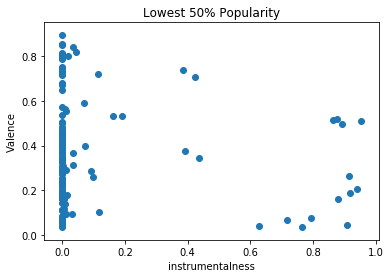

In [468]:
a= pd.DataFrame(concat.loc[df["ranking"] == 5]) 
b= pd.DataFrame(concat.loc[df["ranking"] == 8]) 
plt.title('Lowest 50% Popularity')
plt.xlabel('instrumentalness')
plt.ylabel('Valence')
plt.scatter(a['instrumentalness'],a['valence'])
# plt.scatter(concat['ranking'],concat['instrumentalness'])

print('valence mean: {}'.format(a['valence'].mean()))
print('instrumentalness mean: {}'.format(a['instrumentalness'].mean()))



valence mean: 0.5220075187969925
instrumentalness mean: 0.026870440977443608


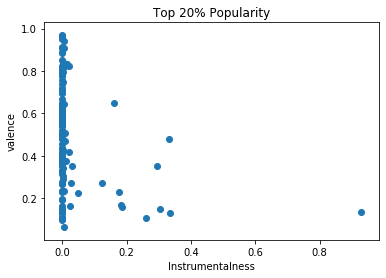

In [469]:
plt.title('Top 20% Popularity')
plt.xlabel('Instrumentalness')
plt.ylabel('valence')
plt.scatter(b['instrumentalness'],b['valence'])

print('valence mean: {}'.format(b['valence'].mean()))
print('instrumentalness mean: {}'.format(b['instrumentalness'].mean()))
